## Import

In [1]:
from wmb import aibs, mm10

from ALLCools.clustering import *
from ALLCools.mcds import MCDS

import pandas as pd

In [2]:
group_name='NOT_DEFINED'
var_dim = 'gene'
cef_cluster_level = 'L3'
chrom_to_remove = ['chrX', 'chrY', 'chrM', 'chrL']
downsample = 500
mc_type = 'CHN'
std_cutoff = 0.05
global_cef = None

In [3]:
# Parameters
cef_cluster_level = "L3"
chrom_to_remove = ["chrX", "chrY", "chrM", "chrL"]
cpu = 1
downsample = 500
global_cef = None
group_name = "CorticalExc"
mc_type = "CHN"
mem_gb = 1
std_cutoff = 0.05
var_dim = "gene"


## Select cells

In [4]:
cells = pd.read_csv('rna_cells.txt', index_col=0, header=None).index
cells.name = 'cell'
cells.size

1412319

## Downsample cells

Downsample large cluster to balance the data and reduce computation time and memory when calculating CEF

In [5]:
annot = aibs.get_tenx_annot()
clusters = annot[cef_cluster_level].to_pandas()
clusters = clusters.loc[cells].copy()

if downsample is not None:
    use_cells = []
    for cluster, sub_series in clusters.groupby(clusters):
        if sub_series.size > downsample:
            _cells = sub_series.sample(downsample, random_state=0).index
        else:
            _cells = sub_series.index
        use_cells += _cells.tolist()
    use_cells = pd.Index(use_cells)
else:
    use_cells = cells
    
use_cells.size

203185

## Basic Feature Filtering

In [6]:
rna_ds = MCDS.open(aibs.AIBS_TENX_V2_ZARR_PATH, var_dim=var_dim, use_obs=use_cells)

rna_ds

<xarray.MCDS>
Dimensions:     (cell: 203185, gene: 32285)
Coordinates:
  * cell        (cell) <U37 'L8TX_201015_01_F02-GGGTTATCATTGAAGA-1' ... 'L8TX...
  * gene        (gene) <U18 'ENSMUSG00000051951' ... 'ENSMUSG00000095041'
    gene_count  (cell) float32 6.365e+03 7.62e+03 ... 6.681e+03 4.487e+03
    gene_name   (gene) <U16 'Xkr4' 'Gm1992' ... 'AC234645.1' 'AC149090.1'
    umi_count   (cell) float32 2.946e+04 3.7e+04 ... 2.428e+04 1.119e+04
Data variables:
    gene_da     (cell, gene) float32 dask.array<chunksize=(5000, 32285), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  gene

In [7]:
gene_meta = mm10.get_gene_metadata()
gene_meta.index.name = var_dim
rna_ds[f'{var_dim}_chrom'] = gene_meta['chrom']
rna_ds[f'{var_dim}_start'] = gene_meta['start']
rna_ds[f'{var_dim}_end'] = gene_meta['end']

In [8]:
rna_ds = rna_ds.remove_chromosome(exclude_chromosome=chrom_to_remove)

1844 gene features in ['chrX', 'chrY', 'chrM', 'chrL'] removed.


In [9]:
rna_ds = rna_ds.remove_black_list_region(black_list_path=mm10.ENCODE_BLACKLIST_PATH)

1260 gene features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


***** WARNING: File /tmp/pybedtools._qa1ouip.tmp has inconsistent naming convention for record:
GL456210.1	9124	58882

***** WARNING: File /tmp/pybedtools._qa1ouip.tmp has inconsistent naming convention for record:
GL456210.1	9124	58882



In [10]:
feature_std = rna_ds[f'{var_dim}_da'].std(dim='cell').to_pandas()
pass_std_filter = (feature_std > std_cutoff).values

rna_ds = rna_ds.sel({var_dim: pass_std_filter})

/opt/conda/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [11]:
rna_ds

<xarray.MCDS>
Dimensions:     (cell: 203185, gene: 19025)
Coordinates:
  * cell        (cell) <U37 'L8TX_201015_01_F02-GGGTTATCATTGAAGA-1' ... 'L8TX...
  * gene        (gene) object 'ENSMUSG00000051951' ... 'ENSMUSG00000095041'
    gene_count  (cell) float32 6.365e+03 7.62e+03 ... 6.681e+03 4.487e+03
    gene_name   (gene) <U16 'Xkr4' 'Gm1992' ... 'CAAA01147332.1' 'AC149090.1'
    umi_count   (cell) float32 2.946e+04 3.7e+04 ... 2.428e+04 1.119e+04
Data variables:
    gene_da     (cell, gene) float32 dask.array<chunksize=(5000, 19025), meta=np.ndarray>
    gene_chrom  (gene) object 'chr1' 'chr1' 'chr1' ... 'JH584295.1' 'JH584304.1'
    gene_start  (gene) int64 3205901 3466587 3647309 3999557 ... 137009 66 52190
    gene_end    (gene) int64 3671498 3513553 3658904 ... 137560 1479 59690
Attributes:
    obs_dim:  cell
    var_dim:  gene

## Get adata

In [12]:
loading_chunk = int(cells.size // 5000 / 20) * 5000
loading_chunk = max(20000, loading_chunk)

# ~20 min to load 4M
adata = rna_ds.get_count_adata(da_name='gene_da',
                               loading_chunk=loading_chunk)

Loading chunk 0-70000/203185


Loading chunk 70000-140000/203185


Loading chunk 140000-203185/203185


In [13]:
adata.obs[cef_cluster_level] = annot[cef_cluster_level].to_pandas()

## CEF Feature Filtering

Cluster enriched feature selection. Use per-cell normalized mC fraction as input, no log transform.

Found 492 clusters to compute feature enrichment score
Computing enrichment score


Computing enrichment score FDR-corrected P values


Selected 6569 unique features


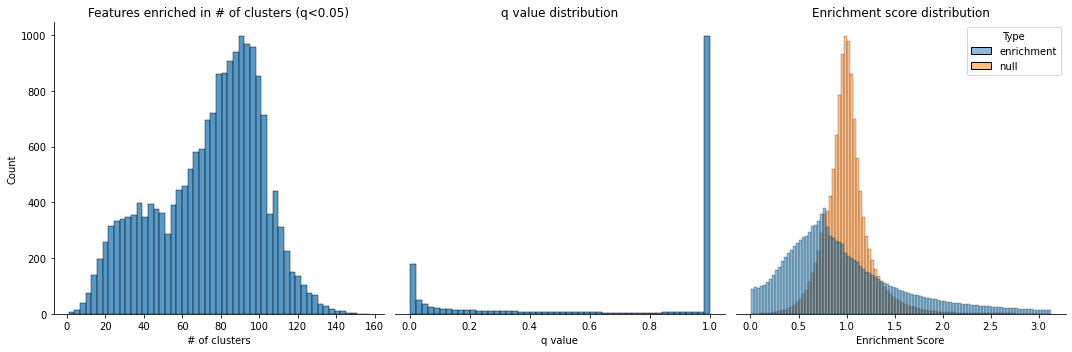

In [14]:
# CEF function take the original mC fraction as input
cluster_enriched_features(adata,
                          cluster_col=cef_cluster_level,
                          top_n=200,
                          alpha=0.05,
                          stat_plot=True,
                          method='rna')

In [15]:
# select CEF only
cef = adata.var[f'{cef_cluster_level}_enriched_features'].copy()

if global_cef is not None:
    # add some global CEF to list
    global_cef = pd.read_csv('global_cef.txt', header=None, index_col=0).index
    cef.loc[cef.index.isin(global_cef)] = True

cef.to_csv('RNA.CEF.csv', header=None)